# Planification de la trajectoire par méthode des potentiels

Projet 3A UBBO

Ce Notebook contient le code destiné à la planification de la trajectoire du robot.


L' objectif est d'entraîner le robot à avoir une meilleure gestion des environnements encombrés (obstacles).

Pour réaliser ces objectifs, nous allons utiliser la méthode des potentiels décrite sur le site personnel de Justin Cano, centralien doctorant en robotique :

- http://justincano.com/doc/chemins_robot.pdf?fbclid=IwAR1HQL9_gErSHmZ8bUF3S5RuzLxiMfttsIlH9hoGkX_ztx-PIlECfQ_sbvg

- http://justincano.com/doc/formation_chemins.pdf?fbclid=IwAR2z8ECIz5iN8EKiPmotLYyd3XRpIu5U2541mlLhpZS8nRaPek3ZdoK7w1A

**Méthode générale proposée:**
1.   Récupération de la carte globale de l'environnement, de la position du robot sur la carte et du point objectif sur la carte
2.   Division de la carte en sous-parties et définition des objectifs intermédiaires :
  - Chaque pièce de la carte va représenter une sous-partie de la carte
  - On va alors diviser la planification de la trajectoire en une série d'objectifs intermédiaires menant à l'objectif final
  - Le prochain objectif du robot est alors défini comme le point lui permettant de sortir de la pièce et qui le rapproche le plus de l'objectif final
3. Puis de manière récursive jusqu'à atteindre l'objectif final : Acquisition de la carte locale grâce au Lidar, carte correspondant à la pièce actuelle, et mise en application de la méthode des potentiels pour rejoindre l'objectif intermédiaire suivant

Dans ce notebook, on ne travaille que sur la map obtenue localement par le robot, qui correspond donc à peu près à la pièce dans laquelle le robot se trouve. Les points précédents 1 et 2 ne sont donc pas traités ici, on passe directement à l'étape 3.

--> Données utilisés : images Lidar

## Import et affichage de l'image (map locale acquise par le LIDAR) :


Le fichier utilisé a été acquis à l'aide du Lidar. Il sert d'exemple pour pouvoir tester et visualiser les effets du code ci-dessous

In [ ]:
# import du fichier de la map au format image PGM
from google.colab import files
files.upload()

Saving my_map.pgm to my_map.pgm


{'my_map.pgm': b'P5\n# CREATOR: map_saver.cpp 0.050 m/pix\n544 480\n255\n\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xc

In [ ]:
# Renvoie l'image PGM sous forme d'une liste de listes
def read_pgm(img):
  (width, height) = img.size
  data = list(img.getdata())
  raster = []
  c=0
  for x in range(height):
    row = []
    for y in range(width):
      row.append(data[c])
      c+=1
    raster.append(row)
  return raster

from PIL import Image # On importe le module
import numpy as np

imgf = Image.open('my_map.pgm') # on ouvre l'image
im = read_pgm(imgf)
mat_im = np.array(im)
print(mat_im)

[[205 205 205 ... 205 205 205]
 [205 205 205 ... 205 205 205]
 [205 205 205 ... 205 205 205]
 ...
 [205 205 205 ... 205 205 205]
 [205 205 205 ... 205 205 205]
 [205 205 205 ... 205 205 205]]


In [ ]:
# affichage des valeurs contenues sur l'image PGM (nuances de gris)
def values_img(img):
  values = []
  for i in range(np.shape(img)[0]):
    for j in range(np.shape(img)[1]):
      x = img[i][j]
      if x not in values:
        values.append(x)
  return values

print(values_img(mat_im))

[205, 0, 254]


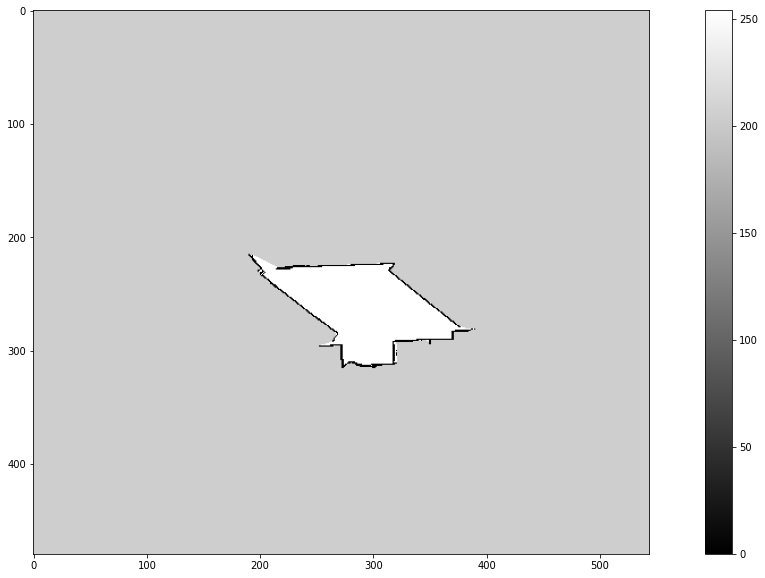

In [ ]:
# affichage de l'image de la map
from scipy.signal import convolve2d
import numpy as np
import matplotlib.pyplot as plt
import yaml

def show_img(img, title=""):
    plt.figure(figsize=(20, 10))
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.colorbar()

img = plt.imread("my_map.pgm")
show_img(img)

Sur l'image ci-dessus, le blanc correspond à la zone inoccupée dans laquelle le robot se situe. Il n'y a pas d'obstacle. Le noir correspond aux obstacles (ici il n'y a que les murs de la pièce). Le gris autour correspond à ce qui est hors du champ de vision du robot.

Cette partie grise est donc inutile à traiter. Afin d'accélérer les calculs effectués par la suite pour la méthode des potentiels, on va chercher à supprimer ce gris superflux. On obtient alors l'image ci-dessous, qui est en quelque sorte un zoom de l'image ci-dessus :

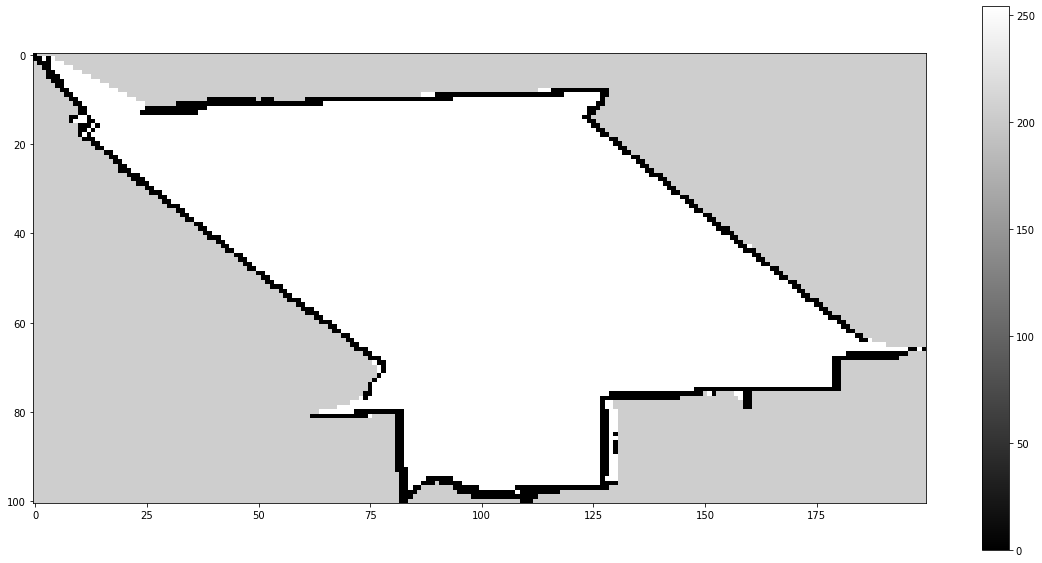

In [ ]:
# affichage de l'image de la map avec un minimum de zone grise
def show_img_with_less_grey(img):
  pattern = img[np.mean(img, axis=1) != 205]
  pattern = pattern.T
  pattern = pattern[np.mean(pattern, axis=1) != 205]
  pattern = pattern.T
  show_img(pattern)

img = plt.imread("my_map.pgm")
show_img_with_less_grey(img)

## Application de la méthode des potentiels pas à pas

On utilise l'image PGM à laquelle on a enlevé les contours gris superflux, ce qui correspond à la 2ème image ci-dessus. Cela permet de diminuer largement les temps de calcul par rapport à la 1ère image contenant beaucoup de gris. On récupère un tableau l'image sous forme d'un tableau numpy avec pour valeurs les nuances de gris (blanc = 0, gris = 205, noir = 255) :

In [ ]:
from PIL import Image # On importe le module
import numpy as np

imgf = Image.open('my_map.pgm') # on ouvre l'image
mat_im_with_grey = read_pgm(imgf)

# Renvoie l'image avec moins de gris
def get_img_with_less_grey(img):
  pattern = img[np.mean(img, axis=1) != 205]
  pattern = pattern.T
  pattern = pattern[np.mean(pattern, axis=1) != 205]
  pattern = pattern.T
  return pattern

mat_im = get_img_with_less_grey(np.array(mat_im_with_grey)) # on supprime le gris superflux autour
print(mat_im)

[[  0 205 205 ... 205 205 205]
 [  0   0 254 ... 205 205 205]
 [205   0   0 ... 205 205 205]
 ...
 [205 205 205 ... 205 205 205]
 [205 205 205 ... 205 205 205]
 [205 205 205 ... 205 205 205]]


On construit la carte binaire d’occupation : à partir de la carte au format image PGM, on calcule une carte constituée de 0 et de 1 uniquement, les 1 correspondant aux obstacles (murs compris) :

In [ ]:
# Calcul de la carte d'occupation (1 si obstacle, 0 sinon)

def occup_map(map):
  map = np.array(map)
  binary_map = np.zeros(np.shape(map), dtype=int)
  for i in range(np.shape(map)[0]):
    for j in range(np.shape(map)[1]):
      if map[i, j] > 0: # si le point de la carte est noir ou gris
        binary_map[i, j] = int(1)
  return binary_map

bin_map = occup_map(mat_im)
print(bin_map)
print(np.shape(bin_map))

[[0 1 1 ... 1 1 1]
 [0 0 1 ... 1 1 1]
 [1 0 0 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
(101, 200)


Puis on dilate les obstacles, c’est-à-dire qu’on augmente les zones interdites, correspondant aux 1 sur la carte binaire. En augmentant ainsi les zones d’obstacles d’un rayon approprié, on peut alors considérer la position du robot comme la position de son centre de gravité sans craindre que les bords du robot ne touchent les obstacles de manière inattendue :

In [ ]:
# Dilatation des obstacles sur la carte d'occupation :

H = max(np.shape(bin_map)[0], np.shape(bin_map)[1]) # nombre de pixels sur un côté de la carte en 2D
R = 5 # rayon du cercle (en nombre de pixels) dans lequel est inscrit le robot 
print(H, R)

def dilate_map(binary_map, H=H, R=R):
  delta = int(R/H)                          # nombre de pixels à dilater
  binary_map = np.array(binary_map)
  dil_bin_map = binary_map[:,:]             # copie de la carte d'occupation
  for i in range(np.shape(binary_map)[0]):
    for j in range(np.shape(binary_map)[1]):
      if binary_map[i, j]==1:
        # dilatation vis-à-vis des lignes d'indices supérieurs :
        k=0
        while k <= delta and i+k < np.shape(binary_map)[0]:
          p=0
          while p <= delta and j+p < np.shape(binary_map)[1]:
            dil_bin_map[i+k, j+p] = 1
            p+=1
          m=0
          while m <= delta and j-m >= 0 :
            dil_bin_map[i+k, j-m] = 1
            m+=1
          k+=1
        # dilatation vis-à-vis des lignes d'indices inférieurs :
        k=1
        while k <= delta and i-k >= 0:
          p=0
          while p <= delta and j+p < np.shape(binary_map)[1]:
            dil_bin_map[i-k, j+p] = 1
            p+=1
          m=0
          while m <= delta and j-m >= 0 :
            dil_bin_map[i-k, j-m] = 1
            m+=1
          k+=1
  return dil_bin_map

dil_map = dilate_map(bin_map)
print(dil_map)
print(np.shape(dil_map))

200 5
[[0 1 1 ... 1 1 1]
 [0 0 1 ... 1 1 1]
 [1 0 0 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
(101, 200)


On définit ci-dessous de manière fictive la position du robot sur la carte et la position visée (objectif). Le code ci-dessous est donc utile ici à titre d'exemple mais ne sera pas utilisé en pratique car les positions du robot et de l'objectif seront fournies via ROS :

In [ ]:
# Définition position robot fictive et position objectif fictive (juste pour l'exemple)

def pos_robot(img):
  for j in range(np.shape(img)[1]): 
    for i in range(np.shape(img)[0]):
      if img[i][j]==0:
        return (i+15, j+15)
  return (False, False)

(xi, yi) = pos_robot(dil_map)
print(xi, yi)

def pos_obj(img):
  for j in range(np.shape(img)[1]): 
    for i in range(np.shape(img)[0]):
      if img[np.shape(img)[0]-1-i][np.shape(img)[1]-1-j]==0:
        return (np.shape(img)[0]-1-i-20, np.shape(img)[1]-1-j-20)
  return (False, False)

(xf, yf) = pos_obj(dil_map)
print(xf, yf)

15 15
46 179


On calcule alors la carte de gradient attractif : sur cette carte de gradients, le potentiel le plus bas est le point objectif, et l’attraction à ce point est d’autant plus forte (le gradient d’autant plus grand) en un point, que ce dernier est loin de l’objectif.

Le potentiel attracteur vise à minimiser la distance au point objectif. Les expressions du potentiel et du gradient attractifs sous fournies dans notre rapport.


In [ ]:
# Calcul de la carte de gradient attractif

def attr_grad(dilated_map, xf, yf, coef=0.1):
  grad = np.zeros((np.shape(dilated_map)[0], np.shape(dilated_map)[1], 2))
  for i in range(np.shape(dilated_map)[0]):
    for j in range(np.shape(dilated_map)[1]):
      grad[i, j, 0] = coef * (i-xf)
      grad[i, j, 1] = coef * (j-yf)
  return grad

attr_map = attr_grad(dil_map, xf, yf)
print(attr_map)
print(np.shape(attr_map))

[[[ -4.6 -17.9]
  [ -4.6 -17.8]
  [ -4.6 -17.7]
  ...
  [ -4.6   1.8]
  [ -4.6   1.9]
  [ -4.6   2. ]]

 [[ -4.5 -17.9]
  [ -4.5 -17.8]
  [ -4.5 -17.7]
  ...
  [ -4.5   1.8]
  [ -4.5   1.9]
  [ -4.5   2. ]]

 [[ -4.4 -17.9]
  [ -4.4 -17.8]
  [ -4.4 -17.7]
  ...
  [ -4.4   1.8]
  [ -4.4   1.9]
  [ -4.4   2. ]]

 ...

 [[  5.2 -17.9]
  [  5.2 -17.8]
  [  5.2 -17.7]
  ...
  [  5.2   1.8]
  [  5.2   1.9]
  [  5.2   2. ]]

 [[  5.3 -17.9]
  [  5.3 -17.8]
  [  5.3 -17.7]
  ...
  [  5.3   1.8]
  [  5.3   1.9]
  [  5.3   2. ]]

 [[  5.4 -17.9]
  [  5.4 -17.8]
  [  5.4 -17.7]
  ...
  [  5.4   1.8]
  [  5.4   1.9]
  [  5.4   2. ]]]
(101, 200, 2)


On calcule également un ensemble de cartes de gradients répulsifs, une pour chaque point obstacle (correspondant à un 1 sur la carte binaire dilatée). On considère pour cela que chaque point obstacle exerce une force de répulsion (correspondant à un potentiel élevé) sur un petit cercle autour de lui, de rayon approprié. Le gradient “répulsif” est d’autant plus fort que l’on est proche de l’obstacle, et d’autant plus faible que l’on s’approche du bord du cercle de répulsion.

Le potentiel répulsif vise à maximiser localement la distance à chaque point obstacle. Les expressions du potentiel et du gradient répulsifs sous fournies dans notre rapport.


In [ ]:
# Calcul de la carte de gradient repulsif

def rep_grad(dilated_map, mu=0.1, rho=1.5*R):
  grad = np.zeros((np.shape(dilated_map)[0], np.shape(dilated_map)[1], 2))
  for i in range(np.shape(dilated_map)[0]):
    for j in range(np.shape(dilated_map)[1]):
      if dilated_map[i, j] == 1:
        # potentiels répulsifs des lignes d'indices supérieurs :
        k=0
        while k < rho and i+k < np.shape(dilated_map)[0]:
          p=0
          while p < rho and j+p < np.shape(dilated_map)[1]:
            if (k, p)!=(0, 0):
              d = (k+p)/2
              grad[i+k, j+p, 0] += -(mu/d**3)*((1/d)-(1/rho))*k
              grad[i+k, j+p, 1] += -(mu/d**3)*((1/d)-(1/rho))*p
            p+=1
          m=0
          while m < rho and j-m >= 0 :
            if (k, m)!=(0, 0):
              d = (k+m)/2
              grad[i+k, j-m, 0] += -(mu/d**3)*((1/d)-(1/rho))*k
              grad[i+k, j-m, 1] += -(mu/d**3)*((1/d)-(1/rho))*(-m)
            m+=1
          k+=1
        # potentiels répulsifs des lignes d'indices inférieurs :
        k=1
        while k < rho and i-k >= 0 :
          p=0
          while p < rho and j+p < np.shape(dilated_map)[1]:
            if (k, p)!=(0, 0):
              d = (k+p)/2
              grad[i-k, j+p, 0] += -(mu/d**3)*((1/d)-(1/rho))*(-k)
              grad[i-k, j+p, 1] += -(mu/d**3)*((1/d)-(1/rho))*p
            p+=1
          m=0
          while m < rho and j-m >= 0 :
            if (k, m)!=(0, 0):
              d = (k+m)/2
              grad[i-k, j-m, 0] += -(mu/d**3)*((1/d)-(1/rho))*(-k)
              grad[i-k, j-m, 1] += -(mu/d**3)*((1/d)-(1/rho))*(-m)
            m+=1
          k+=1
  return grad

rep_map = rep_grad(dil_map)
print(rep_map)
print(np.shape(rep_map))

[[[ 0.56905993  1.81548104]
  [ 0.34463159  1.86221249]
  [ 3.15929899  0.32557521]
  ...
  [ 3.88563434 -0.13155398]
  [ 3.84902863 -0.35182422]
  [ 3.70306817 -1.95519513]]

 [[ 3.46632942  0.40704535]
  [-2.39236002  1.66394677]
  [-2.87048296  0.33378002]
  ...
  [ 0.68646096 -0.15924283]
  [ 0.66565772 -0.41111802]
  [ 0.60636392 -2.10115559]]

 [[ 3.60632584  0.26313462]
  [ 3.23409782 -1.3067392 ]
  [-2.69197702  0.08510137]
  ...
  [ 0.25208578 -0.17087941]
  [ 0.2404492  -0.43192126]
  [ 0.21276035 -2.1377613 ]]

 ...

 [[-0.21276035  2.1377613 ]
  [-0.2404492   0.43192126]
  [-0.25208578  0.17087941]
  ...
  [-0.25208578 -0.17087941]
  [-0.2404492  -0.43192126]
  [-0.21276035 -2.1377613 ]]

 [[-0.60636392  2.10115559]
  [-0.66565772  0.41111802]
  [-0.68646096  0.15924283]
  ...
  [-0.68646096 -0.15924283]
  [-0.66565772 -0.41111802]
  [-0.60636392 -2.10115559]]

 [[-3.70306817  1.95519513]
  [-3.84902863  0.35182422]
  [-3.88563434  0.13155398]
  ...
  [-3.88563434 -0.131553

On calcule ensuite la carte de gradient totale. Il s'agit de la somme des cartes de gradients répulsif et de la carte de gradient attractif :

In [ ]:
# Calcul de la carte de gradient totale
grad_map = attr_map + rep_map
print(grad_map)
print(np.shape(grad_map))

[[[ -4.03094007 -16.08451896]
  [ -4.25536841 -15.93778751]
  [ -1.44070101 -17.37442479]
  ...
  [ -0.71436566   1.66844602]
  [ -0.75097137   1.54817578]
  [ -0.89693183   0.04480487]]

 [[ -1.03367058 -17.49295465]
  [ -6.89236002 -16.13605323]
  [ -7.37048296 -17.36621998]
  ...
  [ -3.81353904   1.64075717]
  [ -3.83434228   1.48888198]
  [ -3.89363608  -0.10115559]]

 [[ -0.79367416 -17.63686538]
  [ -1.16590218 -19.1067392 ]
  [ -7.09197702 -17.61489863]
  ...
  [ -4.14791422   1.62912059]
  [ -4.1595508    1.46807874]
  [ -4.18723965  -0.1377613 ]]

 ...

 [[  4.98723965 -15.7622387 ]
  [  4.9595508  -17.36807874]
  [  4.94791422 -17.52912059]
  ...
  [  4.94791422   1.62912059]
  [  4.9595508    1.46807874]
  [  4.98723965  -0.1377613 ]]

 [[  4.69363608 -15.79884441]
  [  4.63434228 -17.38888198]
  [  4.61353904 -17.54075717]
  ...
  [  4.61353904   1.64075717]
  [  4.63434228   1.48888198]
  [  4.69363608  -0.10115559]]

 [[  1.69693183 -15.94480487]
  [  1.55097137 -17.4481

La carte ainsi obtenue nous permet de calculer la trajectoire par descente de gradients, dont l'expression est fournie dans le rapport :

In [ ]:
# Planification de la trajectoire

import math
alpha = 1.41 # sqrt(2)
traj = []
(x, y) = (xi, yi)
traj.append([x, y])

for k in range(H):
  x_new = x - int(( alpha / math.sqrt(grad_map[x, y, 0]**2 + grad_map[x, y, 1]**2)) * grad_map[x, y, 0])
  y_new = y - int(( alpha / math.sqrt(grad_map[x, y, 0]**2 + grad_map[x, y, 1]**2)) * grad_map[x, y, 1])
  (x, y) = (x_new, y_new)
  traj.append([x, y])

print(len(traj))
print("position initiale :", (xi, yi))
print("position finale :", (x, y))
print("position visée :", (xf, yf))
print("écart :", (x-xf, y-yf))

201
position initiale : (15, 15)
position finale : (40, 155)
position visée : (46, 179)
écart : (-6, -24)


NB : On pourra lisser cette trajectoire en moyennant les points trouvés par la descente de gradient ci-dessus

## Mise au propre de cette méthode des potentiels sous forme de classe objet :

Le code ci-dessous est simplement une mise au propre de la méthode vue ci-dessus codée pas à pas, sous forme de classe objet, en vue de l'implémentation de la méthode sous ROS :

In [ ]:
# import du fichier de la map au format image PGM
from google.colab import files
files.upload()

Saving my_map.pgm to my_map (1).pgm


{'my_map.pgm': b'P5\n# CREATOR: map_saver.cpp 0.050 m/pix\n544 480\n255\n\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xcd\xc

In [ ]:
# Classe propre de la methode des potentiels

from PIL import Image
import numpy as np
import math

class Planification():

  def __init__(self, map_file_pgm_path, robot_position, target_position):
    self.alpha = 1.41                                         # sqrt(2)
    self.R = 5                                                # rayon du cercle (en nombre de pixels) dans lequel est inscrit le robot 
    self.coef = 0.1                                           # coefficient du potentiel attracteur (objectif)
    self.mu = 0.1                                             # coefficient du potentiel répulsif (obstacles)
    self.rho = 1.5 * self.R                                   # rayon d'action du potentiel répulsif (distance autour des obstacles)
    self.robot_position = robot_position                      # position initiale robot sur la carte locale
    self.target_position = target_position                    # position cible sur la carte locale
    self.x = self.robot_position[0]                           # abscisse robot
    self.y = self.robot_position[1]                           # ordonnée robot
    self.xf = self.target_position[0]                         # abscisse objectif
    self.yf = self.target_position[1]                         # ordonnée objectif
    self.track = [[self.x, self.y]]                           # trajectoire robot 
    self.map_file_pgm_path = map_file_pgm_path                # chemin fichier image PGM de la carte locale
    self.map_file_pgm = Image.open(self.map_file_pgm_path)    # image de la map
    self.mat_im_with_grey = None                              # matrice de la map
    self.mat_im = None                                        # matrice de la map sans le gris superflux autour
    self.bin_map = None                                       # map binaire d'occupation
    self.dil_map = None                                       # map binaire d'occupation dilatée
    self.grad_map = None                                      # carte de gradient total
    self.H = None                                             # taille du plus grand côté de la map

  # Renvoie la trajectoire par méthode des potentiels en faisant appel aux autres méthodes de la classe
  def get_track(self):
    self.mat_im_with_grey = self.read_pgm()                                   # lit l'image sous forme matricielle
    self.mat_im = self.get_img_with_less_grey()                               # supprime le gris superflux autour
    self.bin_map = self.occup_map()                                           # crée la map binaire d'occupation
    self.H = max(np.shape(self.bin_map)[0], np.shape(self.bin_map)[1])
    self.dil_map = self.dilate_map()                                          # dilate les obstacles sur la carte binaire d'occupation
    self.grad_map = self.tot_grad()                                           # calcul la carte de gradient total
    for k in range(self.H):                                                   # calcul de la trajectoire par descente de gradients
      x_new = self.x - int(( alpha / math.sqrt(grad_map[self.x, self.y, 0]**2 + grad_map[self.x, self.y, 1]**2)) * grad_map[self.x, self.y, 0])
      y_new = self.y - int(( alpha / math.sqrt(grad_map[self.x, self.y, 0]**2 + grad_map[self.x, self.y, 1]**2)) * grad_map[self.x, self.y, 1])
      (self.x, self.y) = (x_new, y_new)
      self.track.append([self.x, self.y])
    return self.track
  
  # Renvoie la matrice de l'image de la map
  def read_pgm(self):
    img = self.map_file_pgm
    (width, height) = img.size
    data = list(img.getdata())
    raster = []
    c=0
    for x in range(height):
      row = []
      for y in range(width):
        row.append(data[c])
        c+=1
      raster.append(row)
    return np.array(raster)

  # Renvoie l'image de la map avec moins de gris superflux autour
  def get_img_with_less_grey(self):
    img = self.mat_im_with_grey
    pattern = img[np.mean(img, axis=1) != 205]
    pattern = pattern.T
    pattern = pattern[np.mean(pattern, axis=1) != 205]
    pattern = pattern.T
    return pattern

  # Renvoie la carte d'occupation binaire (1 si obstacle, 0 sinon)
  def occup_map(self):
    binary_map = np.zeros(np.shape(self.mat_im), dtype=int)
    for i in range(np.shape(self.mat_im)[0]):
      for j in range(np.shape(self.mat_im)[1]):
        if self.mat_im[i, j] > 0:                       # si le point de la carte est noir ou gris il est considéré comme un obstacle
          binary_map[i, j] = int(1)
    return binary_map

  # Renvoie la carte binaire dilatée
  def dilate_map(self):
    delta = int(self.R/self.H)                          # nombre de pixels à dilater
    dil_bin_map = self.bin_map[:,:]                  # copie de la carte d'occupation
    for i in range(np.shape(self.bin_map)[0]):
      for j in range(np.shape(self.bin_map)[1]):
        if self.bin_map[i, j]==1:
          # dilatation vis-à-vis des lignes d'indices supérieurs :
          k=0
          while k <= delta and i+k < np.shape(self.bin_map)[0]:
            p=0
            while p <= delta and j+p < np.shape(self.bin_map)[1]:
              dil_bin_map[i+k, j+p] = 1
              p+=1
            m=0
            while m <= delta and j-m >= 0 :
              dil_bin_map[i+k, j-m] = 1
              m+=1
            k+=1
          # dilatation vis-à-vis des lignes d'indices inférieurs :
          k=1
          while k <= delta and i-k >= 0:
            p=0
            while p <= delta and j+p < np.shape(self.bin_map)[1]:
              dil_bin_map[i-k, j+p] = 1
              p+=1
            m=0
            while m <= delta and j-m >= 0 :
              dil_bin_map[i-k, j-m] = 1
              m+=1
            k+=1
    return dil_bin_map

  # Renvoie la carte de gradient attractif
  def attr_grad(self):
    grad = np.zeros((np.shape(self.dil_map)[0], np.shape(self.dil_map)[1], 2))
    for i in range(np.shape(self.dil_map)[0]):
      for j in range(np.shape(self.dil_map)[1]):
        grad[i, j, 0] = self.coef * (i-self.xf)
        grad[i, j, 1] = self.coef * (j-self.yf)
    return grad

  # Renvoie la carte de gradient repulsif
  def rep_grad(self):
    grad = np.zeros((np.shape(self.dil_map)[0], np.shape(self.dil_map)[1], 2))
    for i in range(np.shape(self.dil_map)[0]):
      for j in range(np.shape(self.dil_map)[1]):
        if self.dil_map[i, j] == 1:
          # potentiels répulsifs des lignes d'indices supérieurs :
          k=0
          while k < self.rho and i+k < np.shape(self.dil_map)[0]:
            p=0
            while p < self.rho and j+p < np.shape(self.dil_map)[1]:
              if (k, p)!=(0, 0):
                d = (k+p)/2
                grad[i+k, j+p, 0] += -(self.mu/d**3)*((1/d)-(1/self.rho))*k
                grad[i+k, j+p, 1] += -(self.mu/d**3)*((1/d)-(1/self.rho))*p
              p+=1
            m=0
            while m < self.rho and j-m >= 0 :
              if (k, m)!=(0, 0):
                d = (k+m)/2
                grad[i+k, j-m, 0] += -(self.mu/d**3)*((1/d)-(1/self.rho))*k
                grad[i+k, j-m, 1] += -(self.mu/d**3)*((1/d)-(1/self.rho))*(-m)
              m+=1
            k+=1
          # potentiels répulsifs des lignes d'indices inférieurs :
          k=1
          while k < self.rho and i-k >= 0 :
            p=0
            while p < self.rho and j+p < np.shape(self.dil_map)[1]:
              if (k, p)!=(0, 0):
                d = (k+p)/2
                grad[i-k, j+p, 0] += -(self.mu/d**3)*((1/d)-(1/self.rho))*(-k)
                grad[i-k, j+p, 1] += -(self.mu/d**3)*((1/d)-(1/self.rho))*p
              p+=1
            m=0
            while m < self.rho and j-m >= 0 :
              if (k, m)!=(0, 0):
                d = (k+m)/2
                grad[i-k, j-m, 0] += -(self.mu/d**3)*((1/d)-(1/self.rho))*(-k)
                grad[i-k, j-m, 1] += -(self.mu/d**3)*((1/d)-(1/self.rho))*(-m)
              m+=1
            k+=1
    return grad

  # Renvoie la carte de gradient total
  def tot_grad(self):
    grad = self.attr_grad() + self.rep_grad()
    return grad

if __name__ == '__main__':
  (xi, yi) = (15, 15)
  (xf, yf) = (40, 155)
  plan = Planification('my_map.pgm', [xi, yi], [xf, yf])      # [xi, yi] et [xf, yf], respectivement position initiale du robot et position visée, doivent être définis au préalable ici
  traj = plan.get_track()
  print("trajectoire :", traj)
  print(len(traj))
  print("position initiale :", (xi, yi))
  print("position finale :", (x, y))
  print("position visée :", (xf, yf))
  print("écart :", (x-xf, y-yf))

trajectoire : [[15, 15], [15, 16], [15, 17], [15, 18], [15, 19], [15, 20], [15, 21], [15, 22], [15, 23], [15, 24], [15, 25], [15, 26], [15, 27], [15, 28], [15, 29], [15, 30], [15, 31], [15, 32], [15, 33], [15, 34], [15, 35], [15, 36], [15, 37], [15, 38], [15, 39], [15, 40], [15, 41], [15, 42], [15, 43], [15, 44], [15, 45], [15, 46], [15, 47], [15, 48], [15, 49], [15, 50], [15, 51], [15, 52], [15, 53], [15, 54], [15, 55], [15, 56], [15, 57], [15, 58], [15, 59], [15, 60], [15, 61], [15, 62], [15, 63], [15, 64], [15, 65], [15, 66], [15, 67], [15, 68], [15, 69], [15, 70], [15, 71], [15, 72], [15, 73], [15, 74], [15, 75], [15, 76], [15, 77], [15, 78], [15, 79], [15, 80], [15, 81], [15, 82], [15, 83], [15, 84], [15, 85], [15, 86], [15, 87], [15, 88], [15, 89], [15, 90], [15, 91], [15, 92], [15, 93], [15, 94], [15, 95], [15, 96], [15, 97], [15, 98], [15, 99], [15, 100], [15, 101], [15, 102], [15, 103], [15, 104], [15, 105], [15, 106], [15, 107], [15, 108], [15, 109], [15, 110], [15, 111], [15

Remarques :

- Cette méthode nécessite de paramétrer correctement les différents coefficients utilisés (notamment le coefficient de dilatation des obstacles et les coefficients de gradient attratif et répulsifs), de manière à ne pas tomber dans des minima locaux de potentiel.
- Il faudra faire attention également à ne pas choisir un point objectif trop près d’un obstacle (objet ou mur), sinon le potentiel répulsif empêchera le robot de s’en approcher.
- Cette méthode pourra éventuellement être utilisée de manière dynamique (en relançant le calcul tous les p pas de temps par exemple) de façon à pouvoir gérer les obstacles en mouvement.
- On pourra lisser la trajectoire en moyennant les points trouvés par la descente de gradient.